## Import Packages

In [1]:
from data import shortestpath, dataset
from model import shortestPathModel
from func import blackboxOpt
from evalm import SPOEval

In [2]:
import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

## Build Model 

In [3]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-04-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [4]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [5]:
def train(dataloader, opt_model, num_epochs, learning_rate, lambd=10, l1_lambda=1e-3):
    """
    train model with Black-Box Optimizer
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      lambda: black-box optimizer parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
    # set loss
    criterion = nn.L1Loss()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # linear regression
            cp = lr(x)
            # black-box optimizer
            wp = blackboxOpt.apply(opt_model, cp, lambd)
            # objective value
            zp = (wp * c).sum(1).view(-1, 1)
            # l1 loss
            loss = criterion(zp, z)
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # learning rate decay
            cur_lr = learning_rate * 0.6 ** math.floor((epoch / num_epochs) * 10)
            for param_group in optimizer.param_groups:
                param_group['lr'] = cur_lr
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [6]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [7]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [8]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = SPOEval(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 182.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Normalized SPO Loss: 2.48%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 148.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.22it/s]


Normalized SPO Loss: 4.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 248.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.54it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


Normalized SPO Loss: 6.08%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 256.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 234.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


Normalized SPO Loss: 19.78%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 208.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 252.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


Normalized SPO Loss: 1.84%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 263.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 233.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Normalized SPO Loss: 6.23%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 245.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 231.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.35it/s]


Normalized SPO Loss: 22.12%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 404.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.66it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


Normalized SPO Loss: 22.88%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 351.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.06it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s]


Normalized SPO Loss: 1.72%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 199.41it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 230.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Normalized SPO Loss: 4.24%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 286.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 230.95it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Normalized SPO Loss: 6.64%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 224.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 203.72it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Normalized SPO Loss: 17.01%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 346.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.53it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Normalized SPO Loss: 2.04%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 383.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 259.52it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Normalized SPO Loss: 4.12%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 258.23it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 237.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Normalized SPO Loss: 9.30%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 236.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 233.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Normalized SPO Loss: 16.66%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 237.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.13it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Normalized SPO Loss: 1.29%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 342.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.54it/s]


Normalized SPO Loss: 3.31%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 285.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.76it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


Normalized SPO Loss: 6.20%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 395.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.42it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Normalized SPO Loss: 17.20%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 328.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 269.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Normalized SPO Loss: 1.80%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 172.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.22it/s]


Normalized SPO Loss: 3.24%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 128.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Normalized SPO Loss: 8.88%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 211.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 250.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.22it/s]


Normalized SPO Loss: 15.28%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 203.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 249.51it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Normalized SPO Loss: 1.51%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 249.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.43it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Normalized SPO Loss: 5.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 230.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.23it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


Normalized SPO Loss: 12.28%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 343.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


Normalized SPO Loss: 24.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 279.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


Normalized SPO Loss: 1.15%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 288.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.52it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Normalized SPO Loss: 3.29%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 293.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.52it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


Normalized SPO Loss: 7.43%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 330.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.81it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.56it/s]


Normalized SPO Loss: 14.68%



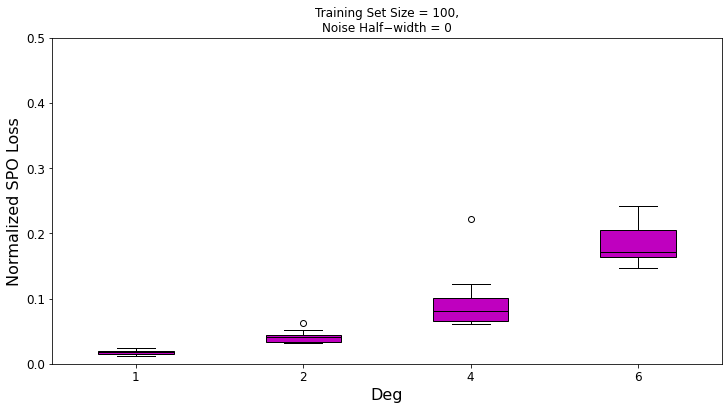

In [9]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df1, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 100, Noise Half−width = 0.5

In [10]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [11]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [12]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = SPOEval(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 296.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.02it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


Normalized SPO Loss: 21.40%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 360.41it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 330.38it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Normalized SPO Loss: 17.59%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 331.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.16it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


Normalized SPO Loss: 20.86%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 413.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.90it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


Normalized SPO Loss: 18.98%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 376.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Normalized SPO Loss: 21.07%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 289.23it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.25it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s]


Normalized SPO Loss: 17.49%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 289.91it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


Normalized SPO Loss: 26.06%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 327.07it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.06it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Normalized SPO Loss: 21.22%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 302.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 223.75it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


Normalized SPO Loss: 19.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 369.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Normalized SPO Loss: 19.90%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 343.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.49it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Normalized SPO Loss: 16.46%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 330.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


Normalized SPO Loss: 26.03%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 246.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.08it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Normalized SPO Loss: 20.75%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 229.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 253.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.28it/s]


Normalized SPO Loss: 17.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 394.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 341.85it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.65it/s]


Normalized SPO Loss: 18.39%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 301.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


Normalized SPO Loss: 26.20%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 168.16it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 224.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Normalized SPO Loss: 21.05%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 284.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Normalized SPO Loss: 17.81%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 234.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 291.62it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


Normalized SPO Loss: 19.24%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 282.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


Normalized SPO Loss: 21.94%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 378.52it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Normalized SPO Loss: 20.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 366.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.41it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.47it/s]


Normalized SPO Loss: 19.15%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 349.52it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.54it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Normalized SPO Loss: 18.40%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 364.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.90it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.47it/s]


Normalized SPO Loss: 21.48%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 295.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


Normalized SPO Loss: 20.87%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 304.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.52it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


Normalized SPO Loss: 17.79%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 328.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.81it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s]


Normalized SPO Loss: 17.10%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 381.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


Normalized SPO Loss: 29.18%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 251.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 330.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


Normalized SPO Loss: 22.00%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 282.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


Normalized SPO Loss: 16.96%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 371.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.66it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Normalized SPO Loss: 17.75%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 234.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Normalized SPO Loss: 28.95%



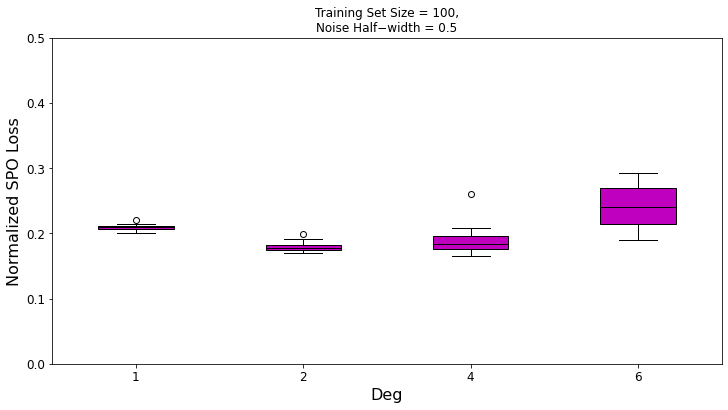

In [13]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df2, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0.5')
plt.show()

### Training Set Size = 1000, Noise Half−width = 0 

In [14]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [15]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [16]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2
        num_epochs = 30
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = SPOEval(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 341.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:11<00:00,  6.38s/it]


Normalized SPO Loss: 0.33%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.09it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:13<00:00,  6.44s/it]


Normalized SPO Loss: 3.57%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 330.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.71it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:05<00:00,  6.17s/it]


Normalized SPO Loss: 10.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.92it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:14<00:00,  6.47s/it]


Normalized SPO Loss: 18.63%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.01it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:13<00:00,  6.47s/it]


Normalized SPO Loss: 0.48%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.43it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:06<00:00,  6.21s/it]


Normalized SPO Loss: 3.59%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.33it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:09<00:00,  6.32s/it]


Normalized SPO Loss: 8.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.69it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:07<00:00,  6.24s/it]


Normalized SPO Loss: 16.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:24<00:00,  6.81s/it]


Normalized SPO Loss: 0.38%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.75it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:02<00:00,  6.09s/it]


Normalized SPO Loss: 1.47%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.05it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:10<00:00,  6.35s/it]


Normalized SPO Loss: 4.68%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.50it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:07<00:00,  6.24s/it]


Normalized SPO Loss: 15.28%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.90it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:02<00:00,  6.07s/it]


Normalized SPO Loss: 0.41%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 370.81it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:11<00:00,  6.38s/it]


Normalized SPO Loss: 4.36%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.67it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:57<00:00,  5.91s/it]


Normalized SPO Loss: 6.48%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.21it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:05<00:00,  6.19s/it]


Normalized SPO Loss: 15.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.06it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:00<00:00,  6.00s/it]


Normalized SPO Loss: 0.30%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 352.68it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:59<00:00,  5.97s/it]


Normalized SPO Loss: 2.46%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.23it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:02<00:00,  6.07s/it]


Normalized SPO Loss: 7.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.44it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:01<00:00,  6.07s/it]


Normalized SPO Loss: 14.65%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.23it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:05<00:00,  6.18s/it]


Normalized SPO Loss: 0.34%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.00it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:58<00:00,  5.96s/it]


Normalized SPO Loss: 2.21%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 386.39it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:00<00:00,  6.02s/it]


Normalized SPO Loss: 10.23%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 234.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 212.03it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:12<00:00,  6.41s/it]


Normalized SPO Loss: 13.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.65it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:06<00:00,  6.22s/it]


Normalized SPO Loss: 0.24%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.76it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:00<00:00,  6.00s/it]


Normalized SPO Loss: 4.21%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.58it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:58<00:00,  5.95s/it]


Normalized SPO Loss: 6.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 330.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.78it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:10<00:00,  6.37s/it]


Normalized SPO Loss: 16.99%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.00it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:14<00:00,  6.49s/it]


Normalized SPO Loss: 0.57%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.37it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:05<00:00,  6.19s/it]


Normalized SPO Loss: 2.62%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.17it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:06<00:00,  6.23s/it]


Normalized SPO Loss: 17.01%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 362.63it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:06<00:00,  6.22s/it]


Normalized SPO Loss: 13.53%



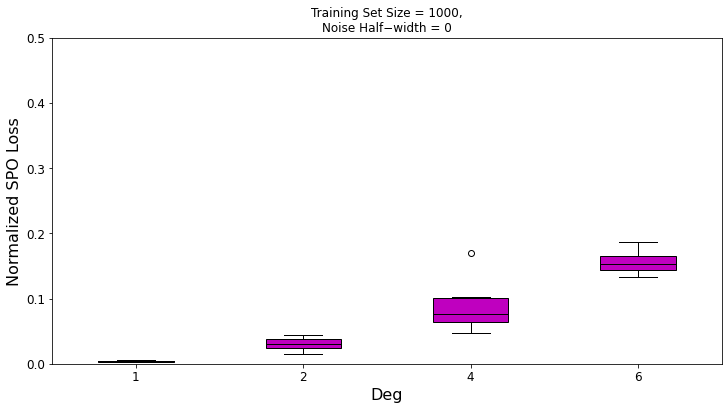

In [17]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df3, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 1000, Noise Half−width = 0.5 

In [18]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [19]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [20]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2
        num_epochs = 30
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = SPOEval(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:03<00:00,  6.11s/it]


Normalized SPO Loss: 20.63%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.22it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:09<00:00,  6.32s/it]


Normalized SPO Loss: 19.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.71it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:03<00:00,  6.11s/it]


Normalized SPO Loss: 23.43%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.11it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:56<00:00,  5.87s/it]


Normalized SPO Loss: 26.83%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 337.15it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:06<00:00,  6.22s/it]


Normalized SPO Loss: 22.23%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.13it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:03<00:00,  6.13s/it]


Normalized SPO Loss: 21.31%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.93it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:14<00:00,  6.49s/it]


Normalized SPO Loss: 33.45%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 280.55it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:22<00:00,  6.75s/it]


Normalized SPO Loss: 25.32%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.31it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:05<00:00,  6.20s/it]


Normalized SPO Loss: 22.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.90it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:14<00:00,  6.49s/it]


Normalized SPO Loss: 21.19%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.09it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:08<00:00,  6.29s/it]


Normalized SPO Loss: 17.32%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 364.87it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.50it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:10<00:00,  6.36s/it]


Normalized SPO Loss: 24.17%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.51it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:08<00:00,  6.28s/it]


Normalized SPO Loss: 21.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.58it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:09<00:00,  6.31s/it]


Normalized SPO Loss: 19.72%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.07it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.18it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:03<00:00,  6.13s/it]


Normalized SPO Loss: 24.71%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.09it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:01<00:00,  6.06s/it]


Normalized SPO Loss: 28.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.23it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:35<00:00,  7.19s/it]


Normalized SPO Loss: 20.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 341.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.56it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:18<00:00,  6.61s/it]


Normalized SPO Loss: 20.56%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 322.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.58it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:11<00:00,  6.37s/it]


Normalized SPO Loss: 17.71%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.28it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:09<00:00,  6.31s/it]


Normalized SPO Loss: 18.50%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 330.48it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:01<00:00,  6.06s/it]


Normalized SPO Loss: 21.80%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:06<00:00,  6.21s/it]


Normalized SPO Loss: 17.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.58it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:03<00:00,  6.12s/it]


Normalized SPO Loss: 18.52%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.24it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:04<00:00,  6.15s/it]


Normalized SPO Loss: 29.77%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.15it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 357.84it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:00<00:00,  6.01s/it]


Normalized SPO Loss: 21.11%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 346.47it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:56<00:00,  5.89s/it]


Normalized SPO Loss: 19.54%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.75it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:10<00:00,  6.35s/it]


Normalized SPO Loss: 17.47%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.56it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:09<00:00,  6.31s/it]


Normalized SPO Loss: 16.34%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.89it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:05<00:00,  6.20s/it]


Normalized SPO Loss: 18.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.55it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:12<00:00,  6.41s/it]


Normalized SPO Loss: 18.14%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.20it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:12<00:00,  6.43s/it]


Normalized SPO Loss: 22.75%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.12it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:07<00:00,  6.26s/it]


Normalized SPO Loss: 25.93%



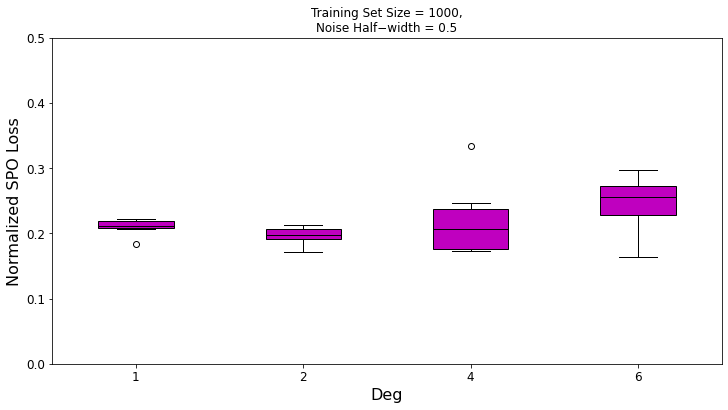

In [21]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df4, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0.5')
plt.show()

## Save File 

In [22]:
df1.to_csv('./res/blackbox_n100.csv', index=False)
df2.to_csv('./res/blackbox_n100_noise.csv', index=False)
df3.to_csv('./res/blackbox_n1000.csv', index=False)
df4.to_csv('./res/blackbox_n1000_noise.csv', index=False)